# CNN on CIFAR-10

CIFAR-10 dataset contains 32x32 color images from 10 classes: __airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__:

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:80%">

# Imports

In [1]:
import warnings
warnings.simplefilter('ignore')

import tensorflow as tf
import keras
from keras import backend as K

# import tensorflow_datasets as tfds

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from keras import regularizers

# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Input, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

%matplotlib inline
import matplotlib.pyplot as plt

print(tf.__version__)
print(keras.__version__)

2.7.0
2.7.0


# Load dataset

In [2]:
(x_train_v, y_train_v), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train_v.shape, y_train_v.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_train_v, y_train_v, test_size=0.2)

In [4]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((40000, 32, 32, 3),
 (40000, 1),
 (10000, 32, 32, 3),
 (10000, 1),
 (10000, 32, 32, 3),
 (10000, 1))

In [5]:
# (x_train, y_train), (x_val, y_val), (x_test, y_test), info = tfds.load('cifar10', split=['train[:40000]', 'val[40000:50000]', 'test[50000:]'], with_info=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [6]:
x_train[0, 0, 0]

array([160, 140,  80], dtype=uint8)

In [7]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Train (50k) samples:", x_train_v.shape, y_train_v.shape)
print("Val samples:", x_val.shape, y_val.shape)

Train samples: (40000, 32, 32, 3) (40000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)
Train (50k) samples: (50000, 32, 32, 3) (50000, 1)
Val samples: (10000, 32, 32, 3) (10000, 1)


In [8]:
x_train[0, :, :, 0]

array([[160, 166, 174, ...,  45, 100,  89],
       [163, 168, 176, ...,  49, 108,  94],
       [161, 167, 174, ...,  50, 110, 106],
       ...,
       [164, 237, 244, ..., 114,  57,  23],
       [141, 226, 246, ..., 105,  45,  27],
       [124, 207, 242, ...,  84,  56,  35]], dtype=uint8)

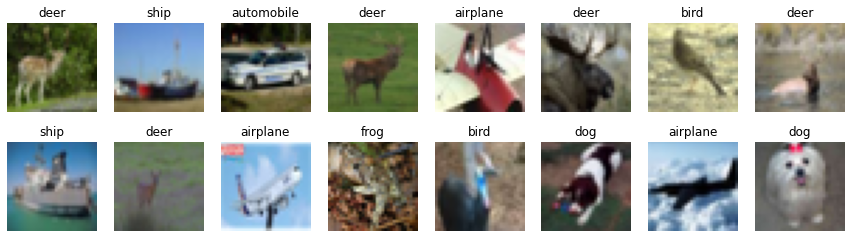

In [9]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index][0]])
plt.show()

# Prepare data

* normalize the input like $x_{\text{norm}} = \frac{x}{255}$
* We need to convert class labels to one-hot encoded vectors. Use `keras.utils.to_categorical`.

In [10]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
x_train = x_train / 255
y_train_c = y_train
y_train = tf.keras.utils.to_categorical(y_train, 10)

x_test = x_test / 255
y_test_c = y_test
y_test = tf.keras.utils.to_categorical(y_test, 10)

x_val = x_val / 255
y_val_c = y_val
y_val = tf.keras.utils.to_categorical(y_val, 10)

x_train_v = x_train_v / 255
y_train_v_c = y_train_v
y_train_v = tf.keras.utils.to_categorical(y_train_v, 10)

# Define CNN architecture

In [11]:
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(x_train)

In [12]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
#     model.add(Input(shape=32, 32, 3))
    model.add(Conv2D(128, 3, activation='relu', input_shape=(32, 32, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(128, 3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, 3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(256, 3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, 2, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(512, 2, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

In [13]:
# describe model
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0

In [14]:
# model.non_trainable_variables

# Train model

In [15]:
INIT_LR = 0.001  # initial learning rate
BATCH_SIZE = 64
EPOCHS = 100

K.clear_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adamax(lr=INIT_LR),
              metrics=['accuracy'])

In [16]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 30:
        lrate = 0.0005
    if epoch > 70:
        lrate = 0.0003
    if epoch > 90:
        lrate = 0.0001
    return lrate

In [26]:
model.fit_generator(datagen.flow(x_train_v, y_train_v, batch_size=BATCH_SIZE), 
                    steps_per_epoch=x_train.shape[0] // BATCH_SIZE, 
                    epochs=100, 
                    verbose=1, 
                    validation_data=(x_test, y_test), 
                    callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/100
625/625 [==============================] - 66s 105ms/step - loss: 2.1956 - accuracy: 0.2196 - val_loss: 1.9241 - val_accuracy: 0.2922 - lr: 0.0010
Epoch 2/100
625/625 [==============================] - 65s 105ms/step - loss: 1.8047 - accuracy: 0.3399 - val_loss: 1.5036 - val_accuracy: 0.4490 - lr: 0.0010
Epoch 3/100
625/625 [==============================] - 66s 105ms/step - loss: 1.6041 - accuracy: 0.4192 - val_loss: 1.3000 - val_accuracy: 0.5412 - lr: 0.0010
Epoch 4/100
625/625 [==============================] - 69s 111ms/step - loss: 1.4446 - accuracy: 0.4869 - val_loss: 1.1729 - val_accuracy: 0.5957 - lr: 0.0010
Epoch 5/100
625/625 [==============================] - 69s 111ms/step - loss: 1.3115 - accuracy: 0.5453 - val_loss: 1.0753 - val_accuracy: 0.6399 - lr: 0.0010
Epoch 6/100
625/625 [==============================] - 67s 107ms/step - loss: 1.1847 - accuracy: 0.5952 - val_loss: 0.9201 - val_accuracy: 0.6881 - lr: 0.0010
Epoch 7/100
625/625 [=========================

# Evaluate model

In [27]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
accuracy_score(y_test_c, y_pred_test_classes)  # 0.848 (40), 0.8632 (60), 0.8687 (70)

0.9104

[[936   6  11   0   3   0   2   2  32   8]
 [  2 971   0   0   0   0   0   0   4  23]
 [ 25   1 880  12  20  10  38   7   5   2]
 [  9   6  28 764  38  67  51  17   8  12]
 [  2   1  28   9 905   3  39  12   1   0]
 [  6   3  19  68  17 837  21  20   4   5]
 [  4   2  10   7   3   0 966   3   3   2]
 [  7   1  15   5  26   8   3 929   2   4]
 [ 14   5   2   0   0   0   2   1 967   9]
 [  7  30   0   1   2   0   0   0  11 949]]


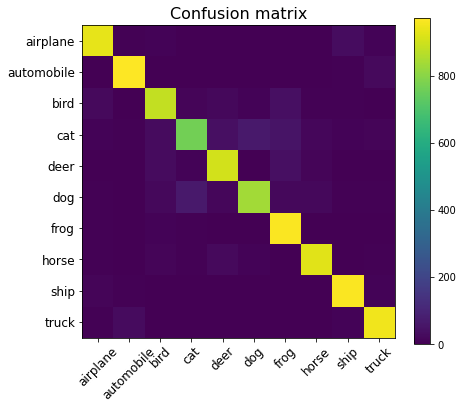

Test accuracy: 0.9104


In [12]:
# confusion matrix and accuracy
print(confusion_matrix(y_test_c, y_pred_test_classes))
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_c, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_c, y_pred_test_classes))

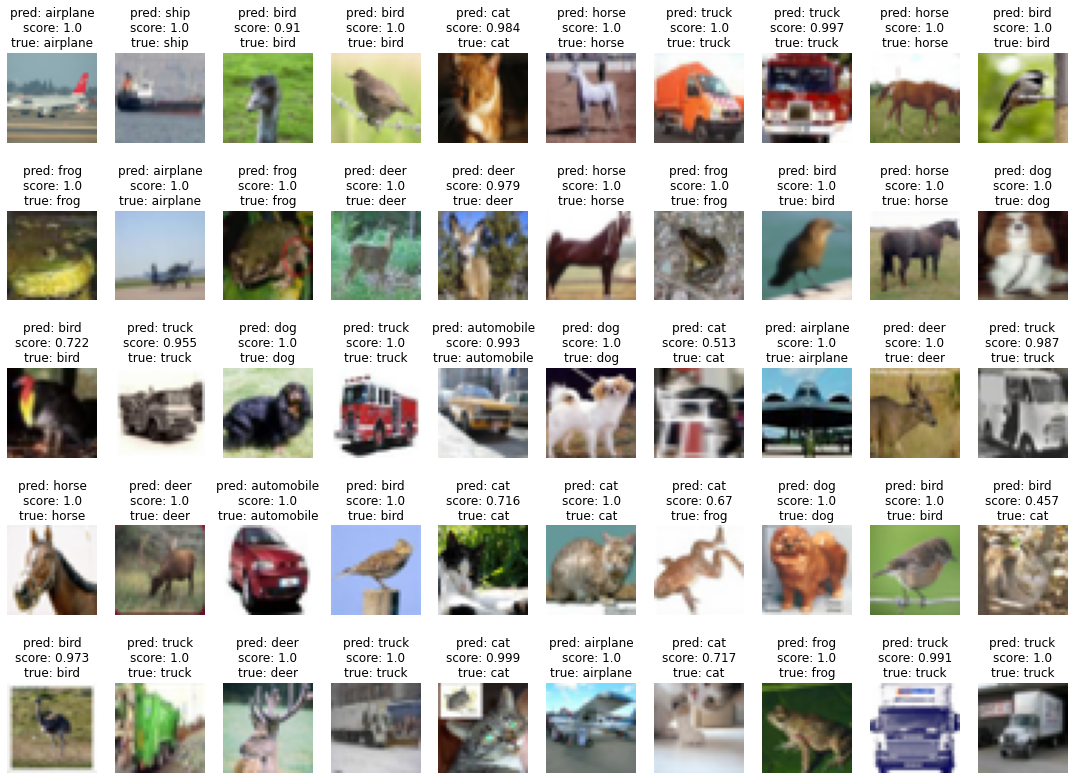

In [15]:
# inspect preditions
cols = 10
rows = 5
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[(y_test_c[random_index])[0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(pred_label, pred_proba, true_label))
plt.show()

### Save and load model

In [30]:
export_path = './saved_models/{}'.format(9104)
model.save(export_path)

INFO:tensorflow:Assets written to: ./saved_models/9104\assets


./saved_models/9104

In [17]:
loaded = tf.keras.models.load_model('./saved_models/9104')

In [18]:
y_pred_test = loaded.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
accuracy_score(y_test_c, y_pred_test_classes)

0.9104